In [67]:
import pydicom
import numpy as np
from pathlib import Path
from tqdm import tqdm 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import datetime
from IPython.display import clear_output
from IPython.display import HTML
from tqdm import tqdm
indexing="xy"

In [68]:
# Parameters for Cube Geometry
cube_half_width = 75 # mm
cube_inside_bevel = 67 # mm
bevel_radius = cube_half_width - cube_inside_bevel
cube_HU = -15

sphere_diameter = 7.5 # mm
sphere_centers = np.array([[-10,-25,-30], [ 10,-15,-15], [0,0,0], [-20, 20, 10],[ 20, 30,20]]) # From specifications
sphere_centers = np.array([[-25, 30,-10], [-15, 15, 10], [0,0,0], [ 20,-10,-20],[ 30,-20,20]]) # From our CT scans
sphere_HU = 3060

# Parameters to jitter cube surface to make it imperfect
include_jitter = False
max_jitter = 0.02 # mm

# Parameters for Image Geometry
image_matrix_size = 256
image_physical_size = 192 # mm
image_pixel_size = image_physical_size / image_matrix_size
image_positions = np.arange(image_matrix_size)*image_pixel_size + image_pixel_size/2 - image_physical_size/2


# Parameters for Slice Geometry
number_of_slices = 256
image_physical_length = 192 # mm
slice_width = image_physical_length / number_of_slices # plus one?
slice_positions = np.arange(number_of_slices)*slice_width + slice_width/2 - image_physical_length/2

def is_in_sphere(loc):
    """Checks whether the point loc is in the cube
    
    PARAMETERS
    ----------
    loc : list of float
        A list of length 3 corresponding to the x, y and z coordinates of the point
    
    RETURNS
    -------
    True if the point is in the a sphere, else False
    
    """
    
    assert len(loc) == 3, "loc must be a list of three floating point integers"
    
    for origin in sphere_centers:
        vec = loc - origin
        dist = np.linalg.norm(vec)
        if dist <= sphere_diameter/2:
            return True
    
    return False

def is_in_cube(loc, rounded_edges=True):
    """Checks whether the point loc is in the cube
    
    PARAMETERS
    ----------
    loc : list of float
        A list of length 3 corresponding to the x, y and z coordinates of the point
    rounded_edges: bool
        If True, evaluates for a cube with rounded edges. If false, assumes cube
        has sharp edges (default is True)
    
    RETURNS
    -------
    True if the point is in the cube, else False
    
    """
    
    assert len(loc) == 3, "loc must be a list of three floating point integers"
    
    # Cube is symmetric, take abs of x,y,z, convert to ndarray which allows slicing
    loc = np.abs(loc)
    
    # Case 1: Any of the values are greater than the cube half-width, return false:
    if any(loc > cube_half_width):
        return False
    
    # If we are not using rounded edges, then we are done. Return True
    if not rounded_edges:
        return True
    
    # Case 2: All of the values are less than the cube_inside_bevel, return True:
    if all(loc <= cube_inside_bevel):
        return True
    
    # Case 3: If exactly one dimension is greater than cube_inside_bevel, 
    # then the point is adjacent to a cube face, return True:
    if sum(loc > cube_inside_bevel) == 1:
        return True

    # Case 4: If exactly two dimensions are greater than cube_inside_bevel, 
    # then the point is adjacent to a cube edge. The point defined by the two
    # dimensions that are greater than the cube_inside_bevel must be within a 
    # radius of bevel_radius of the point cube_inside_bevel*[1,1]:
    if sum(loc > cube_inside_bevel) == 2:
        
        # Get the indicies whose value is greater than cube_inside_bevel
        tf_array = loc > cube_inside_bevel
    
        # Create a 2D vector from the origin to the point in the edge region
        origin = cube_inside_bevel*np.ones((3,1))
        
        vec = loc[tf_array] - origin[tf_array]
        dist = np.linalg.norm(vec)
        if dist <= bevel_radius:
            return True
        else:
            return False
    
    # Case 5: If exactly three dimensions are greater than cube_inside_bevel, 
    # then the point is adjacent to a cube corner. The point must be within a 
    # radius of bevel_radius of the point cube_inside_bevel*[1,1,1]:
    if sum(loc > cube_inside_bevel) == 3:
        origin = cube_inside_bevel*np.ones((3,1))
        vec = loc - origin
        dist = np.linalg.norm(vec)
        if dist <= bevel_radius:
            return True
        else:
            return False
    
    
def is_in_sphere_np(x, y, z):
    """
    
    PARAMETERS
    ----------
    x : list of float
        A list of image coordinates in the x-dimension
    y : list of float
        A list of image coordinates in the y-dimension
    z : list of float
        A list of image coordinates in the z-dimension
    
    RETURNS
    -------
    A 3D array of shape (len(x),len(y),len(z)), where the array value (i,j,k) is True 
    if the point x[i], y[j], z[k] is located in a in the a sphere, else False
    
    """
        
    XX, YY, ZZ = np.meshgrid(x, y, z, indexing=indexing)
    
    is_in_sphere_array = np.zeros(XX.shape, dtype=bool)
    
    for origin in sphere_centers:
        DXX = XX - origin[0]
        DYY = YY - origin[1]
        DZZ = ZZ - origin[2]
        
        quad_sum = np.square(DXX) + np.square(DYY) + np.square(DZZ)
        
        is_in_this_sphere = (quad_sum <= (sphere_diameter/2)**2)
        
        np.logical_or(is_in_this_sphere, is_in_sphere_array, out=is_in_sphere_array)
    
    return is_in_sphere_array

def is_in_cube_np(x, y, z, rounded_edges=False):
    """
    
    PARAMETERS
    ----------
    x : list of float
        A list of image coordinates in the x-dimension
    y : list of float
        A list of image coordinates in the y-dimension
    z : list of float
        A list of image coordinates in the z-dimension
    rounded_edges : bool
        If True, evaluates for a cube with rounded edges. If false, assumes cube
        has sharp edges (default is False)
    
    RETURNS
    -------
    A 3D array of shape (len(x),len(y),len(z)), where the array value (i,j,k) is True 
    if the point x[i], y[j], z[k] is located in a in the a cube, else False
    
    """
    
    def is_in_rectangular_prism(XX, YY, ZZ, xmax, ymax, zmax):
        in_prism_x = abs(XX) <= xmax
        in_prism_y = abs(YY) <= ymax
        in_prism_z = abs(ZZ) <= zmax
        
        return np.logical_and.reduce([in_prism_x, in_prism_y, in_prism_z])
        
    
    XX, YY, ZZ = np.meshgrid(image_positions, image_positions, slice_positions, indexing=indexing)

    is_in_cube_array = np.zeros(XX.shape, dtype=bool)

    if rounded_edges:
        
        # The rounded cube can be broken into a set of rectangular prisms, cylinders and spheres
        
        # Check if the points are in the three rectangular prisms
        in_prism_x = is_in_rectangular_prism(XX, YY, ZZ, cube_half_width, cube_inside_bevel, cube_inside_bevel)
        in_prism_y = is_in_rectangular_prism(XX, YY, ZZ, cube_inside_bevel, cube_half_width, cube_inside_bevel)
        in_prism_z = is_in_rectangular_prism(XX, YY, ZZ, cube_inside_bevel, cube_inside_bevel, cube_half_width)
        in_prisms = np.logical_or.reduce([in_prism_x, in_prism_y, in_prism_z])
        
        # Check if the points are in the sphere
        DXX = abs(XX) - cube_inside_bevel
        DYY = abs(YY) - cube_inside_bevel
        DZZ = abs(ZZ) - cube_inside_bevel
        
        quad_sum = np.square(DXX) + np.square(DYY) + np.square(DZZ)
        
        in_sphere = (quad_sum <= bevel_radius**2)
        
        # Check if the points are in the three cylinders
        
        # Z-axis cylinders
        DXX = abs(XX) - cube_inside_bevel
        DYY = abs(YY) - cube_inside_bevel
        quad_sum = np.square(DXX) + np.square(DYY)
        in_cyl_radius = (quad_sum <= bevel_radius**2)
        in_cyl_length = abs(ZZ) <= cube_inside_bevel
        
        in_cyl_z = np.logical_and(in_cyl_radius, in_cyl_length)
        
        # Y-axis cylinders
        DXX = abs(XX) - cube_inside_bevel
        DZZ = abs(ZZ) - cube_inside_bevel
        quad_sum = np.square(DXX) + np.square(DZZ)
        in_cyl_radius = (quad_sum <= bevel_radius**2)
        in_cyl_length = abs(YY) <= cube_inside_bevel
        
        in_cyl_y = np.logical_and(in_cyl_radius, in_cyl_length)
        
        # X-axis cylinders
        DYY = abs(YY) - cube_inside_bevel
        DZZ = abs(ZZ) - cube_inside_bevel
        quad_sum = np.square(DYY) + np.square(DZZ)
        in_cyl_radius = (quad_sum <= bevel_radius**2)
        in_cyl_length = abs(XX) <= cube_inside_bevel
        
        in_cyl_x = np.logical_and(in_cyl_radius, in_cyl_length)
        
        in_cylinders = np.logical_or.reduce([in_cyl_x, in_cyl_y, in_cyl_z])
        
        # Put it all together
        is_in_cube_array = np.logical_or.reduce([in_prisms, in_sphere, in_cylinders])
        
    else:

        is_in_cube_array = is_in_rectangular_prism(XX, YY, ZZ, cube_half_width, cube_half_width, cube_half_width)

    return is_in_cube_array


# Building a metadata writer

def write_meta_data(dcm):

    # Instance creation
    now = datetime.datetime.now()
    now_date = now.strftime("%Y%m%d")
    now_time = now.strftime("%H%M%S")

    # Dates
    dcm.InstanceCreationDate = now_date
    dcm.StudyDate = now_date
    dcm.SeriesDate = now_date
    dcm.ContentDate = now_date

    # Times
    dcm.InstanceCreationTime = now_time
    dcm.StudyTime = now_time
    dcm.SeriesTime = now_time
    dcm.ContentTime = now_time

    # Description
    dcm.StudyDescription = "Virtual AlignRT Cube"
    dcm.SeriesDescription = f"Matrix size: {image_matrix_size}, Image size: {image_physical_size} mm"
    dcm.OperatorsName = "djj379"

    # Patient information
    dcm.PatientName = "ZZUWQA^AlignRTCube"
    dcm.PatientID = "20210101DJJ"
    dcm.PatientBirthDate = now_date
    dcm.PatientBirthTime = now_time

    return dcm

def write_image_dimensions(dcm, slice_index, slice_width, slice_positions, image_positions, image_matrix_size, image_pixel_size):
    
    # Image Dimensions
    dcm.SliceThickness = slice_width
    dcm.ImagePositionPatient = [image_positions[0], image_positions[0], slice_positions[0]]
    dcm.SliceLocation = slice_positions[slice_index]
    dcm.Rows = image_matrix_size
    dcm.Columns = image_matrix_size
    dcm.PixelSpacing = [image_pixel_size, image_pixel_size]
    
def play_slices_movie(slices):

    fig, ax = plt.subplots()

    sorted_slices = sorted(slices, key=lambda x: x.SliceLocation)
    # ims is a list of lists, each row is a list of artists to draw in the
    # current frame; here we are just animating one artist, the image, in
    # each frame
    ims = []
    for i in range(len(sorted_slices)):
        im = ax.imshow(
            sorted_slices[i].pixel_array, 
            origin="upper",
            extent=(image_positions[0], image_positions[-1], image_positions[-1], image_positions[0]),            
            animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)

    return HTML(ani.to_jshtml())    
    
def get_slices_from_dir(dicom_dir):

    dicom_path = Path(dicom_dir)

    # load the DICOM files
    files = []

    for fname in dicom_path.iterdir():
        # print("loading: {}".format(fname))
        files.append(pydicom.dcmread(fname))


    print("file count: {}".format(len(files)))

    # skip files with no SliceLocation (eg scout views)
    slices = []
    skipcount = 0
    for f in files:

        if hasattr(f, 'SliceLocation'):
            slices.append(f)       
        else:
            skipcount = skipcount + 1

    print("skipped, no SliceLocation: {}".format(skipcount))

    return slices

def get_files_from_dir(dicom_dir):

    dicom_path = Path(dicom_dir)

    # load the DICOM files
    files = []

    for fname in dicom_path.iterdir():
        # print("loading: {}".format(fname))
        files.append(pydicom.dcmread(fname))


    print("file count: {}".format(len(files)))

    # skip files with no SliceLocation (eg scout views)
    slices = []
    structure_set = None
    rt_plan = None
    skipcount = 0
    for f in files:

        if f.Modality == "CT":
            slices.append(f) 
        elif f.Modality == "RTSTRUCT":
            structure_set = f
        elif f.Modality == "RTPLAN":
            rt_plan = f
        else:
            skipcount = skipcount + 1

    print("skipped, not CT, Structure Set, or Plan: {}".format(skipcount))

    return (slices, structure_set, rt_plan)

def slices_have_unique_locations(slices):
    locations = [ s.SliceLocation for s in slices ]
    locations_set = set(locations)
    
    return len(locations) == len(locations_set)


In [69]:
# Create 3D data matrix
image_xyz = (image_positions, image_positions, slice_positions)
pixel_map = np.zeros((image_matrix_size, image_matrix_size, number_of_slices))-1000
tf_in_sphere = is_in_sphere_np(*image_xyz)
tf_in_cube = is_in_cube_np(*image_xyz, True)

pixel_map[tf_in_cube] = cube_HU
pixel_map[tf_in_sphere] = sphere_HU

# Correct map to account for -1000 intercept in DICOM file
pixel_map += 1000

In [ ]:
# Create 3D data matrix with mottling
num_samples = 200
image_dims = (image_matrix_size, image_matrix_size, number_of_slices)
pixel_map = np.zeros(image_dims)

for _ in tqdm(range(num_samples)):
    
    this_pixel_map = np.zeros(image_dims)-1000
    
    # Randomlly shift the standard grid locations to simulate mottle
    rand_x_shift = image_pixel_size*(np.random.rand()-0.5)
    rand_y_shift = image_pixel_size*(np.random.rand()-0.5)
    rand_z_shift = slice_width*(np.random.rand()-0.5)

    image_xyz = (
        image_positions + rand_x_shift, 
        image_positions + rand_y_shift, 
        slice_positions + rand_z_shift,
    )
    
    tf_in_sphere = is_in_sphere_np(*image_xyz)
    tf_in_cube = is_in_cube_np(*image_xyz, True)

    this_pixel_map[tf_in_cube] = cube_HU
    this_pixel_map[tf_in_sphere] = sphere_HU
    

    pixel_map += this_pixel_map

pixel_map /= num_samples

# Correct map to account for -1000 intercept in DICOM file
pixel_map += 1000

 20%|██████████████████████████████▌                                                                                                                          | 40/200 [09:46<39:30, 14.81s/it]

file count: 258
skipped, no SliceLocation: 2


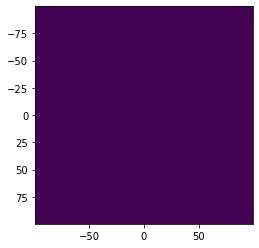

In [31]:
output_dir = Path("output/")

orig_slices = get_slices_from_dir("../visionrt-cube-dicom/data/")
assert slices_have_unique_locations(orig_slices), "Slices do not have unique locations"
updated_slices = []
for i, s in enumerate(orig_slices):
    
    output_filename = output_dir / f"CT.{i}.dcm"
    s_updated = write_meta_data(s)
    
    s_updated.SliceThickness = slice_width
    s_updated.InstanceNumber = i
    s_updated.ImagePositionPatient = [image_positions[0],image_positions[0],slice_positions[i]]
    s_updated.SliceLocation = slice_positions[i]
    s_updated.Rows, s_updated.Columns = [image_matrix_size, image_matrix_size]
    s_updated.PixelSpacing = [image_pixel_size, image_pixel_size]

    s_updated.WindowCenter, s_updated.WindowWidth = [40, 400]
    
    s_updated.PixelData = pixel_map[:,:,i].astype(np.int16).tobytes()
    
    updated_slices.append(s_updated)
    
    s_updated.save_as(output_filename)
    
play_slices_movie(updated_slices)


In [35]:
(ct, ss, pl) = get_files_from_dir("../visionrt-cube-dicom/data/")
ss

file count: 258
skipped, not CT, Structure Set, or Plan: 0


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 184
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: RT Structure Set Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.246.352.71.4.508639987643.90206.20170803100725
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.246.352.70.2.1.160.3
(0002, 0013) Implementation Version Name         SH: 'DCIE 2.2'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0012) Instance Creation Date              DA: '20200709'
(0008, 0013) Instance Creation Time              TM: '112408'
(0008, 0016) SOP Class UID                       UI: RT Structure Set Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.246.352.71.4.508639987643.90206.20170803100725
(

In [47]:
cd = ss.ROIContourSequence[0].ContourSequence[0].ContourData

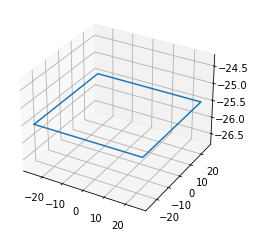

In [60]:
data = np.array(cd).reshape(1024,3)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs = data[:,0], ys = data[:,1], zs = data[:,2])

In [56]:
data[:,0]

array([-25.5, -25.3, -25.1, ..., -25.6, -25.6, -25.6])

In [61]:
pl

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 186
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: RT Plan Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.246.352.71.5.508639987643.295452.20180521143957
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.246.352.70.2.1.160.3
(0002, 0013) Implementation Version Name         SH: 'DCIE 2.2'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0012) Instance Creation Date              DA: '20200709'
(0008, 0013) Instance Creation Time              TM: '112412'
(0008, 0016) SOP Class UID                       UI: RT Plan Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.246.352.71.5.508639987643.295452.20180521143957
(0008, 0020) Stud